## Initialization

In [1]:
# Loading all the libraries
import pandas as pd
import seaborn as sb
from scipy import stats as st
import numpy as np
from math import factorial
from functools import reduce
%matplotlib inline
import matplotlib.pyplot as plt
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)


            


## Load data

In [2]:
# Load the data files into different DataFrames
calls = pd.read_csv("/datasets/megaline_calls.csv")
internet = pd.read_csv("/datasets/megaline_internet.csv")
messages = pd.read_csv("/datasets/megaline_messages.csv")
plans = pd.read_csv("/datasets/megaline_plans.csv")
users = pd.read_csv("/datasets/megaline_users.csv")


## Prepare the data

* I will go through each dataframe and check to determine if they contain any problematic values such as missing values or incorrect datatypes, duplicates, etc.

* Calls Table: 
* No missing values
* The call_date column is currently "object" type, but should be converted to datetime object type
* No duplicate rows

* Above, the ["call_date"] column has been successfully converted to datetime

* There are no missing values, duplicates in the internet dataframe. The ["session_date"] has been converted to datetime.

* The users table column contained missing values only in the [churn_date] column. It was previously noted that if NaN values appeared in this column, that would indicate that the users are currently still registered on the plan. 
* I replaced all NaN values with "current_user" to make it more readable. It is important to note that only 34/500 rows initially contained a non-NaN value, indicating that those were the only users that stopped the service. 
* It might be a good idea to see if there is any link between having a churn date and type of plan. Dates found in the [churn_date] column have been converted to datetime.



In [3]:
# Print a sample of data for plans
plans.info()
print(plans.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10           

In [4]:
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN



## Users

In [5]:
# Print the general/summary information about the users' DataFrame
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [6]:
# Print a sample of data for users
users.head()


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


* The column ["churn_date"] contains several missing values, which will be treated.

In [7]:
users["churn_date"] = pd.to_datetime(users["churn_date"], format="%Y-%m-%d")
users.fillna("current_user", inplace=True)

In [8]:
users["reg_date"] = pd.to_datetime(users["reg_date"], format="%Y-%m-%d")


## Calls

In [9]:
# Print the general/summary information about the calls' DataFrame
calls["call_date"] = pd.to_datetime(calls["call_date"], format= "%Y-%m-%d")
calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


In [10]:
# Print a sample of data for calls
calls.head()


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [11]:
print(calls.head(40))
calls.info()
print(calls.duplicated().sum())
calls.nunique()

          id  user_id  call_date  duration
0    1000_93     1000 2018-12-27      8.52
1   1000_145     1000 2018-12-27     13.66
2   1000_247     1000 2018-12-27     14.48
3   1000_309     1000 2018-12-28      5.76
4   1000_380     1000 2018-12-30      4.22
5   1000_388     1000 2018-12-31      2.20
6   1000_510     1000 2018-12-27      5.75
7   1000_521     1000 2018-12-28     14.18
8   1000_530     1000 2018-12-28      5.77
9   1000_544     1000 2018-12-26      4.40
10  1000_693     1000 2018-12-31      4.31
11  1000_705     1000 2018-12-31     12.78
12  1000_735     1000 2018-12-29      1.70
13  1000_778     1000 2018-12-28      3.29
14  1000_826     1000 2018-12-26      9.96
15  1000_842     1000 2018-12-27      5.85
16    1001_0     1001 2018-09-06     10.06
17    1001_1     1001 2018-10-12      1.00
18    1001_2     1001 2018-10-17     15.83
19    1001_4     1001 2018-12-05      0.00
20    1001_5     1001 2018-12-13      6.27
21    1001_6     1001 2018-12-04      7.19
22    1001_

id           137735
user_id         481
call_date       351
duration       2802
dtype: int64

## Messages

In [12]:
# Print the general/summary information about the messages' DataFrame
messages.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [13]:
# Print a sample of data for messages
messages.head()
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [14]:
messages.duplicated().sum()
messages["message_date"] = pd.to_datetime(messages["message_date"], format="%Y-%m-%d")


## Internet

In [15]:
# Print the general/summary information about the internet DataFrame
internet.info()
internet.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


,user_id,mb_used
count,104825.000000,104825.000000
mean,1242.496361,366.713701
std,142.053913,277.170542
min,1000.000000,0.000000
25%,1122.000000,136.080000
50%,1236.000000,343.980000
75%,1367.000000,554.610000
max,1499.000000,1693.470000


In [16]:
# Print a sample of data for the internet traffic
print(internet.duplicated().sum())
print(internet.isna().sum())


0
id              0
user_id         0
session_date    0
mb_used         0
dtype: int64


In [17]:
internet["session_date"] = pd.to_datetime(calls["call_date"], format= "%Y-%m-%d")
internet.head()
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [18]:
internet["month"] = internet["session_date"].dt.month
calls["month"] = calls["call_date"].dt.month
messages["month"]=messages["message_date"].dt.month

In [19]:
print(internet.head())
print(calls.head())
print(users.head())
print(messages.head())


         id  user_id session_date  mb_used  month
0   1000_13     1000   2018-12-27    89.86     12
1  1000_204     1000   2018-12-27     0.00     12
2  1000_379     1000   2018-12-27   660.40     12
3  1000_413     1000   2018-12-28   270.99     12
4  1000_442     1000   2018-12-30   880.22     12
         id  user_id  call_date  duration  month
0   1000_93     1000 2018-12-27      8.52     12
1  1000_145     1000 2018-12-27     13.66     12
2  1000_247     1000 2018-12-27     14.48     12
3  1000_309     1000 2018-12-28      5.76     12
4  1000_380     1000 2018-12-30      4.22     12
   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4     

In [20]:
users.head()
city=users[["user_id", "city"]]
city

,user_id,city
0,1000,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,1001,"Seattle-Tacoma-Bellevue, WA MSA"
2,1002,"Las Vegas-Henderson-Paradise, NV MSA"
3,1003,"Tulsa, OK MSA"
4,1004,"Seattle-Tacoma-Bellevue, WA MSA"
...,...,...
495,1495,"New York-Newark-Jersey City, NY-NJ-PA MSA"
496,1496,"New Orleans-Metairie, LA MSA"
497,1497,"Los Angeles-Long Beach-Anaheim, CA MSA"
498,1498,"New York-Newark-Jersey City, NY-NJ-PA MSA"


* To make things a bit simpler, since all the tables (internet & messages as well as users and calls) since they all had "user-id" in common.

In [21]:
# Print out the plan conditions and make sure they are clear for you
plans.head()


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Aggregate data per user


In [22]:
# Calculate the number of calls made by each user per month. Save the result.
print(calls.head())
number_of_calls_per_user = calls.groupby(["user_id", "month"])["id"].count().reset_index()
number_of_calls_per_user 

         id  user_id  call_date  duration  month
0   1000_93     1000 2018-12-27      8.52     12
1  1000_145     1000 2018-12-27     13.66     12
2  1000_247     1000 2018-12-27     14.48     12
3  1000_309     1000 2018-12-28      5.76     12
4  1000_380     1000 2018-12-30      4.22     12


,user_id,month,id
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64
...,...,...,...
2253,1498,12,39
2254,1499,9,41
2255,1499,10,53
2256,1499,11,45


In [23]:
calls["number_calls"] = number_of_calls_per_user["id"]
calls.head()
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [24]:
# Calculate the amount of minutes spent by each user per month. Save the result.
total_minutes_spent = calls.groupby(["user_id", "month"])["duration"].sum().reset_index()


In [25]:
total_minutes_spent

,user_id,month,duration
0,1000,12,116.83
1,1001,8,171.14
2,1001,9,297.69
3,1001,10,374.11
4,1001,11,404.59
...,...,...,...
2253,1498,12,324.77
2254,1499,9,330.37
2255,1499,10,363.28
2256,1499,11,288.56


In [26]:
# Calculate the number of messages sent by each user per month. Save the result.
plans1 = users[["user_id", "plan"]]
one = total_minutes_spent.merge(plans1, on="user_id")

In [27]:
messages.head()

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


In [28]:

total_monthly_texts = messages.groupby(["user_id", "month"])["id"].count().reset_index()
total_monthly_texts= total_monthly_texts.rename({"id":"total_monthly_texts"}, axis=1).reset_index()
two= one.merge(total_monthly_texts, on=["user_id","month"])
two

,user_id,month,duration,plan,index,total_monthly_texts
0,1000,12,116.83,ultimate,0,11
1,1001,8,171.14,surf,1,30
2,1001,9,297.69,surf,2,44
3,1001,10,374.11,surf,3,53
4,1001,11,404.59,surf,4,36
...,...,...,...,...,...,...
1768,1496,9,389.94,surf,1801,21
1769,1496,10,301.16,surf,1802,18
1770,1496,11,291.88,surf,1803,13
1771,1496,12,278.61,surf,1804,11


In [29]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
monthly_data_usage=internet.groupby(["user_id", "month"])["mb_used"].sum().reset_index()
monthly_data_usage
three=two.merge(monthly_data_usage, on=["user_id", "month"])
number_of_calls_per_user.rename({'id':'number_of_calls'}, axis=1, inplace=True)
four=three.merge(number_of_calls_per_user, on=["user_id", "month"])
final_rec=four.merge(city, on="user_id")
final_rec.isna().sum()

user_id                0
month                  0
duration               0
plan                   0
index                  0
total_monthly_texts    0
mb_used                0
number_of_calls        0
city                   0
dtype: int64

In [30]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
final_rec.head()

,user_id,month,duration,plan,index,total_monthly_texts,mb_used,number_of_calls,city
0,1000,12,116.83,ultimate,0,11,1901.47,16,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,1001,8,171.14,surf,1,30,7131.50,27,"Seattle-Tacoma-Bellevue, WA MSA"
2,1001,9,297.69,surf,2,44,13311.04,49,"Seattle-Tacoma-Bellevue, WA MSA"
3,1001,10,374.11,surf,3,53,20406.45,65,"Seattle-Tacoma-Bellevue, WA MSA"
4,1001,11,404.59,surf,4,36,20873.07,64,"Seattle-Tacoma-Bellevue, WA MSA"


In [31]:
final_rec.isna().sum()

user_id                0
month                  0
duration               0
plan                   0
index                  0
total_monthly_texts    0
mb_used                0
number_of_calls        0
city                   0
dtype: int64

In [32]:
# Add the plan information
def add_plan(row):
    if row == "surf":
        return float(.03)
    else:
        return float(.01)
add_plan("surf")
final_rec["usd_per_minute"] = final_rec["plan"].apply(add_plan)
final_rec.head()
final_rec["usd_per_message"] = final_rec["plan"].apply(add_plan)


In [33]:
def add_gb(row):
    if row == "surf":
        return 10
    else:
        return 7
final_rec["usd_per_gb"] = final_rec["plan"].apply(add_gb)

In [34]:
def add_pay(row):
    if row == "surf":
        return 20
    else:
        return 70
final_rec["usd_monthly_pay"] = final_rec["plan"].apply(add_pay)

In [35]:
def add_minutes(row):
    if row == "surf":
        return 500
    else:
        return 3000
final_rec["minutes_included"] = final_rec["plan"].apply(add_minutes)

In [36]:
def add_mb(row):
    if row == "surf":
        return 15360
    else:
        return 30720
final_rec["mb_included"] = final_rec["plan"].apply(add_mb) 


In [37]:
def add_messages(row):
    if row == "surf":
        return 50
    else:
        return 1000
final_rec["messages_included"] = final_rec["plan"].apply(add_messages) 

In [38]:
def convertmb(row):
        return round(row/1000)
final_rec["gb_used"]=final_rec["mb_used"].apply(convertmb)


In [39]:
final_rec.head()

,user_id,month,duration,plan,index,total_monthly_texts,mb_used,number_of_calls,city,usd_per_minute,usd_per_message,usd_per_gb,usd_monthly_pay,minutes_included,mb_included,messages_included,gb_used
0,1000,12,116.83,ultimate,0,11,1901.47,16,"Atlanta-Sandy Springs-Roswell, GA MSA",0.01,0.01,7,70,3000,30720,1000,2
1,1001,8,171.14,surf,1,30,7131.50,27,"Seattle-Tacoma-Bellevue, WA MSA",0.03,0.03,10,20,500,15360,50,7
2,1001,9,297.69,surf,2,44,13311.04,49,"Seattle-Tacoma-Bellevue, WA MSA",0.03,0.03,10,20,500,15360,50,13
3,1001,10,374.11,surf,3,53,20406.45,65,"Seattle-Tacoma-Bellevue, WA MSA",0.03,0.03,10,20,500,15360,50,20
4,1001,11,404.59,surf,4,36,20873.07,64,"Seattle-Tacoma-Bellevue, WA MSA",0.03,0.03,10,20,500,15360,50,21


In [40]:
final_rec.isna().sum()

user_id                0
month                  0
duration               0
plan                   0
index                  0
total_monthly_texts    0
mb_used                0
number_of_calls        0
city                   0
usd_per_minute         0
usd_per_message        0
usd_per_gb             0
usd_monthly_pay        0
minutes_included       0
mb_included            0
messages_included      0
gb_used                0
dtype: int64

In [41]:
def included_min(row):
    if row == "surf":
        return 500
    else: 
        return 3000
final_rec["included_min"]=final_rec["plan"].apply(included_min)


In [42]:
def included_texts(row):
    if row == "surf":
        return 50
    else:
        return 1000
final_rec["included_texts"]=final_rec["plan"].apply(included_texts)

In [43]:
def included_gb(row):
    if row == "surf":
        return 15
    else:
        return 30
final_rec["included_gb"]=final_rec["plan"].apply(included_gb)

In [44]:
# Calculate the monthly revenue for each user
surf_month=20
ultimate_month=70
final_rec.isna().sum()


user_id                0
month                  0
duration               0
plan                   0
index                  0
total_monthly_texts    0
mb_used                0
number_of_calls        0
city                   0
usd_per_minute         0
usd_per_message        0
usd_per_gb             0
usd_monthly_pay        0
minutes_included       0
mb_included            0
messages_included      0
gb_used                0
included_min           0
included_texts         0
included_gb            0
dtype: int64

In [45]:
final_rec["gb_diff"] = final_rec["gb_used"] - final_rec["included_gb"]
final_rec.head()


,user_id,month,duration,plan,index,total_monthly_texts,mb_used,number_of_calls,city,usd_per_minute,...,usd_per_gb,usd_monthly_pay,minutes_included,mb_included,messages_included,gb_used,included_min,included_texts,included_gb,gb_diff
0,1000,12,116.83,ultimate,0,11,1901.47,16,"Atlanta-Sandy Springs-Roswell, GA MSA",0.01,...,7,70,3000,30720,1000,2,3000,1000,30,-28
1,1001,8,171.14,surf,1,30,7131.50,27,"Seattle-Tacoma-Bellevue, WA MSA",0.03,...,10,20,500,15360,50,7,500,50,15,-8
2,1001,9,297.69,surf,2,44,13311.04,49,"Seattle-Tacoma-Bellevue, WA MSA",0.03,...,10,20,500,15360,50,13,500,50,15,-2
3,1001,10,374.11,surf,3,53,20406.45,65,"Seattle-Tacoma-Bellevue, WA MSA",0.03,...,10,20,500,15360,50,20,500,50,15,5
4,1001,11,404.59,surf,4,36,20873.07,64,"Seattle-Tacoma-Bellevue, WA MSA",0.03,...,10,20,500,15360,50,21,500,50,15,6


In [46]:
def rev(row):
    if row > 0:
        return row
    else:
        return 0


In [47]:
final_rec["extra_gb"] = final_rec["gb_diff"].apply(rev)
final_rec.head()

,user_id,month,duration,plan,index,total_monthly_texts,mb_used,number_of_calls,city,usd_per_minute,...,usd_monthly_pay,minutes_included,mb_included,messages_included,gb_used,included_min,included_texts,included_gb,gb_diff,extra_gb
0,1000,12,116.83,ultimate,0,11,1901.47,16,"Atlanta-Sandy Springs-Roswell, GA MSA",0.01,...,70,3000,30720,1000,2,3000,1000,30,-28,0
1,1001,8,171.14,surf,1,30,7131.50,27,"Seattle-Tacoma-Bellevue, WA MSA",0.03,...,20,500,15360,50,7,500,50,15,-8,0
2,1001,9,297.69,surf,2,44,13311.04,49,"Seattle-Tacoma-Bellevue, WA MSA",0.03,...,20,500,15360,50,13,500,50,15,-2,0
3,1001,10,374.11,surf,3,53,20406.45,65,"Seattle-Tacoma-Bellevue, WA MSA",0.03,...,20,500,15360,50,20,500,50,15,5,5
4,1001,11,404.59,surf,4,36,20873.07,64,"Seattle-Tacoma-Bellevue, WA MSA",0.03,...,20,500,15360,50,21,500,50,15,6,6


In [48]:
final_rec[final_rec["total_monthly_texts"] > 100]
final_rec.head()

,user_id,month,duration,plan,index,total_monthly_texts,mb_used,number_of_calls,city,usd_per_minute,...,usd_monthly_pay,minutes_included,mb_included,messages_included,gb_used,included_min,included_texts,included_gb,gb_diff,extra_gb
0,1000,12,116.83,ultimate,0,11,1901.47,16,"Atlanta-Sandy Springs-Roswell, GA MSA",0.01,...,70,3000,30720,1000,2,3000,1000,30,-28,0
1,1001,8,171.14,surf,1,30,7131.50,27,"Seattle-Tacoma-Bellevue, WA MSA",0.03,...,20,500,15360,50,7,500,50,15,-8,0
2,1001,9,297.69,surf,2,44,13311.04,49,"Seattle-Tacoma-Bellevue, WA MSA",0.03,...,20,500,15360,50,13,500,50,15,-2,0
3,1001,10,374.11,surf,3,53,20406.45,65,"Seattle-Tacoma-Bellevue, WA MSA",0.03,...,20,500,15360,50,20,500,50,15,5,5
4,1001,11,404.59,surf,4,36,20873.07,64,"Seattle-Tacoma-Bellevue, WA MSA",0.03,...,20,500,15360,50,21,500,50,15,6,6


In [49]:
final_rec["text_diff"] = final_rec["total_monthly_texts"] - final_rec["included_texts"]
def rev2(row):
    if row > 0:
        return row
    else:
        return 0
final_rec["extra_text"] = final_rec["text_diff"].apply(rev2)
final_rec.head()

,user_id,month,duration,plan,index,total_monthly_texts,mb_used,number_of_calls,city,usd_per_minute,...,mb_included,messages_included,gb_used,included_min,included_texts,included_gb,gb_diff,extra_gb,text_diff,extra_text
0,1000,12,116.83,ultimate,0,11,1901.47,16,"Atlanta-Sandy Springs-Roswell, GA MSA",0.01,...,30720,1000,2,3000,1000,30,-28,0,-989,0
1,1001,8,171.14,surf,1,30,7131.50,27,"Seattle-Tacoma-Bellevue, WA MSA",0.03,...,15360,50,7,500,50,15,-8,0,-20,0
2,1001,9,297.69,surf,2,44,13311.04,49,"Seattle-Tacoma-Bellevue, WA MSA",0.03,...,15360,50,13,500,50,15,-2,0,-6,0
3,1001,10,374.11,surf,3,53,20406.45,65,"Seattle-Tacoma-Bellevue, WA MSA",0.03,...,15360,50,20,500,50,15,5,5,3,3
4,1001,11,404.59,surf,4,36,20873.07,64,"Seattle-Tacoma-Bellevue, WA MSA",0.03,...,15360,50,21,500,50,15,6,6,-14,0


In [50]:
final_rec["call_diff"] = final_rec["duration"] - final_rec["included_min"]
def rev3(row):
    if row > 0:
        return row
    else:
        return 0
final_rec["extra_minutes"] = final_rec["call_diff"].apply(rev3)
final_rec.columns


Index(['user_id', 'month', 'duration', 'plan', 'index', 'total_monthly_texts',
       'mb_used', 'number_of_calls', 'city', 'usd_per_minute',
       'usd_per_message', 'usd_per_gb', 'usd_monthly_pay', 'minutes_included',
       'mb_included', 'messages_included', 'gb_used', 'included_min',
       'included_texts', 'included_gb', 'gb_diff', 'extra_gb', 'text_diff',
       'extra_text', 'call_diff', 'extra_minutes'],
      dtype='object')

In [51]:
final_rec["text_revenue"] = final_rec["usd_per_message"] * final_rec["extra_text"]
final_rec["call_revenue"] = final_rec["usd_per_minute"] * final_rec["extra_minutes"]
final_rec["data_revenue"] = final_rec["usd_per_gb"] * final_rec["extra_gb"]
final_rec["total_revenue"] = final_rec["text_revenue"] + final_rec["call_revenue"] + final_rec["data_revenue"] + final_rec['usd_monthly_pay']
final_rec[final_rec["total_revenue"] > 800]


,user_id,month,duration,plan,index,total_monthly_texts,mb_used,number_of_calls,city,usd_per_minute,...,gb_diff,extra_gb,text_diff,extra_text,call_diff,extra_minutes,text_revenue,call_revenue,data_revenue,total_revenue
64,1028,12,40.68,ultimate,75,74,143047.36,6,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",0.01,...,113,113,-926,0,-2959.32,0.0,0.00,0.0,791,861.00
1243,1374,12,252.79,surf,1402,83,133170.94,51,"Louisville/Jefferson County, KY-IN MSA",0.03,...,118,118,33,33,-247.21,0.0,0.99,0.0,1180,1200.99


In [52]:
final_rec.groupby(["plan"])["total_revenue"].sum()

plan
surf        64723.5195
ultimate    42945.0000
Name: total_revenue, dtype: float64

* The above code indicates that the surf plan generated about 33% more revenue than the ultimate plan.

## Study user behaviour

[Calculate some useful descriptive statistics for the aggregated and merged data, which typically reveal an overall picture captured by the data. Draw useful plots to help the understanding. Given that the main task is to compare the plans and decide on which one is more profitable, the statistics and the plots should be calculated on a per-plan basis.]

[There are relevant hints in the comments for Calls but they are not provided for Messages and Internet though the principle of statistical study is the same for them as for Calls.]

### Calls

Text(0, 0.5, 'Average Call Duration in Minutes')

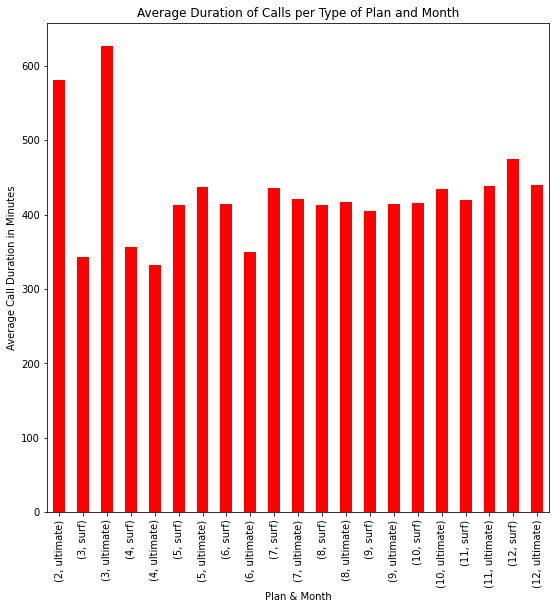

In [53]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it.
final_rec.groupby(["month", "plan"])["duration"].mean().plot(kind="bar", color="red", figsize=(9,9))
plt.title("Average Duration of Calls per Type of Plan and Month")
plt.xlabel("Plan & Month")
plt.ylabel("Average Call Duration in Minutes")
#avg_call_duration = sb.barplot(x="plan", y="duration", data=final_rec, hue="month", capsize=.5)

plan
surf        427.041926
ultimate    426.267894
Name: duration, dtype: float64
plan
surf        421.26
ultimate    406.62
Name: duration, dtype: float64


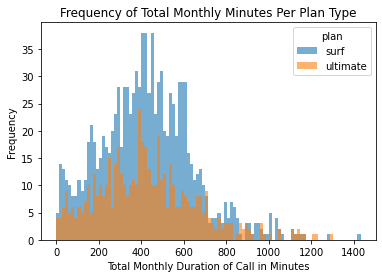

In [54]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.

print(final_rec.groupby("plan")["duration"].mean())
print(final_rec.groupby("plan")["duration"].median())
final_rec.pivot(columns="plan", values="duration").plot.hist(bins=100, alpha=0.6)
plt.xlabel("Total Monthly Duration of Call in Minutes")
plt.title("Frequency of Total Monthly Minutes Per Plan Type")
plt.show()

* Overall, it appears that ultimate plan users tend to have a lower overall monthly call duration as compared to surf plan users. Grouping each set of data per plan, we find that both data for ultimate users and surf users are skewed to the right as reflected by the histogram and given that the mean is greater than the median.

In [55]:
final_rec.columns


Index(['user_id', 'month', 'duration', 'plan', 'index', 'total_monthly_texts',
       'mb_used', 'number_of_calls', 'city', 'usd_per_minute',
       'usd_per_message', 'usd_per_gb', 'usd_monthly_pay', 'minutes_included',
       'mb_included', 'messages_included', 'gb_used', 'included_min',
       'included_texts', 'included_gb', 'gb_diff', 'extra_gb', 'text_diff',
       'extra_text', 'call_diff', 'extra_minutes', 'text_revenue',
       'call_revenue', 'data_revenue', 'total_revenue'],
      dtype='object')

In [56]:
monthly_duration= final_rec.groupby(["plan","month"])[["duration"]].mean()
monthly_duration

duration
plan     month            
surf     3      343.587500
         4      356.975714
         5      412.758684
         6      413.582712
         7      435.674304
         8      412.232768
         9      404.185347
         10     415.852363
         11     420.053839
         12     474.524826
ultimate 2      581.190000
         3      625.940000
         4      332.733333
         5      437.030625
         6      349.665556
         7      421.205500
         8      416.853704
         9      414.367794
         10     434.936941
         11     438.496569
         12     440.247398

In [57]:
final_rec["daily_minutes"] = calls["duration"]
final_rec.head()
final_rec.isna().sum()

user_id                0
month                  0
duration               0
plan                   0
index                  0
total_monthly_texts    0
mb_used                0
number_of_calls        0
city                   0
usd_per_minute         0
usd_per_message        0
usd_per_gb             0
usd_monthly_pay        0
minutes_included       0
mb_included            0
messages_included      0
gb_used                0
included_min           0
included_texts         0
included_gb            0
gb_diff                0
extra_gb               0
text_diff              0
extra_text             0
call_diff              0
extra_minutes          0
text_revenue           0
call_revenue           0
data_revenue           0
total_revenue          0
daily_minutes          0
dtype: int64

In [58]:
surf_data = final_rec.query('plan == "surf"')
ultimate_data = final_rec.query('plan=="ultimate"')
a= surf_data.groupby("month")["duration"].mean()
b= ultimate_data.groupby("month")["duration"].mean()


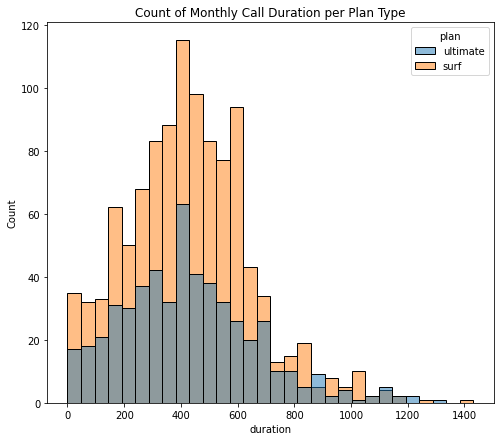

Surf: Average for duration is 409
Surf: Variance for duration is 1359
Surf: SD for duration is 37
Ultimate: Average for duration is 445
Ultimate: Variance for duration is 7551
Ultimate: SD for duration is 87


In [59]:

surf_data = final_rec.query('plan == "surf"')
ultimate_data = final_rec.query('plan=="ultimate"')
monthly_duration1= final_rec.groupby("month")
def call_duration_stats(duration):
    fig, ax=plt.subplots(figsize=(8,7))
    ax=sb.histplot(final_rec, x="duration", hue="plan")
    
    surf_mean= round(a.mean())
    surf_var= round(a.var())
    surf_std= round(a.std())
    ult_mean=round(b.mean())
    ult_var= round(b.var())
    ult_std= round(b.std())
    plt.title("Count of Monthly Call Duration per Plan Type")
    plt.show()
    print("Surf: Average for", duration, "is", surf_mean)
    print("Surf: Variance for", duration, "is", surf_var)
    print("Surf: SD for", duration, "is", surf_std)

    print("Ultimate: Average for", duration, "is", ult_mean)
    print("Ultimate: Variance for", duration, "is", ult_var)
    print("Ultimate: SD for", duration, "is", ult_std)

call_duration_stats("duration")

* Although the mean monthly call duration for each plan are comparable, the monthly call duration for the Ultimate users have a much higher variance (almost 7 times higher) than that of Surf users. 
* It is important to note that there are twice as much data for "surf" (1080 rows) plan users as compared to "ultimate" plan users (527 rows). 
* Considering that the dataset for Ultimate users is small compare to Surf users, it is reasonable to understand why there is more spread and variability within the data. 
* As sample sizes increase, we would expect less and less variability. Nonetheless, the magnitude of the difference in the monthly call duration variance between the two plans still appears to be significant. Further hypothesis testing will confirm this.

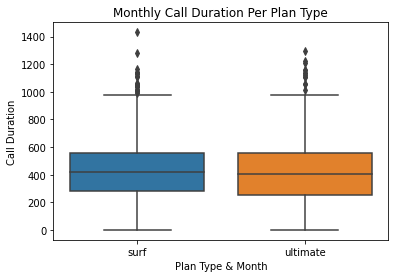

Surf Monthly Call Duration Median: 421.2599999999999
Ultimate Monthly Call Duration Median: 406.6199999999999


In [60]:
,# Plot a boxplot to visualize the distribution of the monthly call duration
#final_rec.pivot(columns=["month","plan"], values="duration").boxplot(figsize=(9,9))
h=final_rec.pivot(columns="plan", values="duration")
sb.boxplot(data=h)
plt.xlabel("Plan Type & Month")
plt.ylabel("Call Duration")
plt.title("Monthly Call Duration Per Plan Type")
plt.show()
print("Surf Monthly Call Duration Median:", surf_data["duration"].median())
print("Ultimate Monthly Call Duration Median:", ultimate_data["duration"].median())


* As this plot shows, the medians of both plans are quite similiar, as are the means (mentioned above). However, we can see that the Ultimate users tend to be more spread out in terms of monthly call duration The Ultimate IQR box appears slightly larger although this plot might not be the best representation, as we are not comparing similar sample sizes, so the difference in variation may be harder to spot.

### Messages

plan
surf        40.022222
ultimate    47.941176
Name: total_monthly_texts, dtype: float64

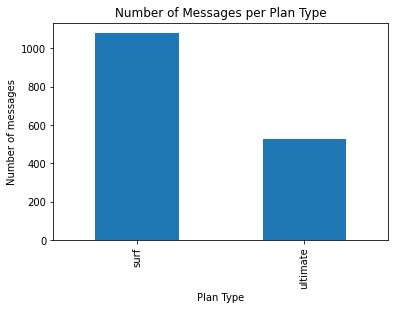

In [61]:
# Compare the number of messages users of each plan tend to send each month
final_rec.groupby("plan")["total_monthly_texts"].count().plot(kind="bar")
plt.xlabel("Plan Type")
plt.ylabel("Number of messages")
plt.title("Number of Messages per Plan Type")
final_rec.groupby("plan")["total_monthly_texts"].mean()

plan
surf        15635
ultimate     8042
Name: gb_used, dtype: int64

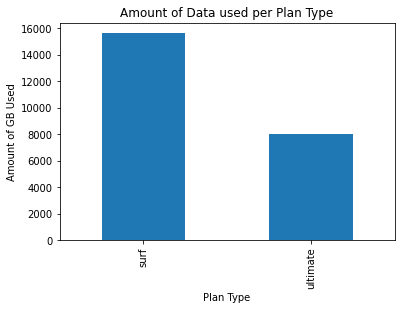

In [62]:
# Compare the amount of internet traffic consumed by users per plan
final_rec.groupby(["plan"])["gb_used"].sum().plot(kind="bar")
plt.xlabel("Plan Type")
plt.ylabel("Amount of GB Used")
plt.title("Amount of Data used per Plan Type")
final_rec.groupby(["plan"])["gb_used"].sum()

* When it comes to messaging, ultimate users tend to send more messages. However, internet traffic is considerably cigher in surf users as compared to ultimate users. 
* It is important to note that the data is disproportionately distributed, as there is far more data on surf users than ultimate users.Thus, even the slightest difference seen in ultimate user data is something to consider.

### Internet

Text(0.5, 1.0, 'Monthly Data Usage per Plan')

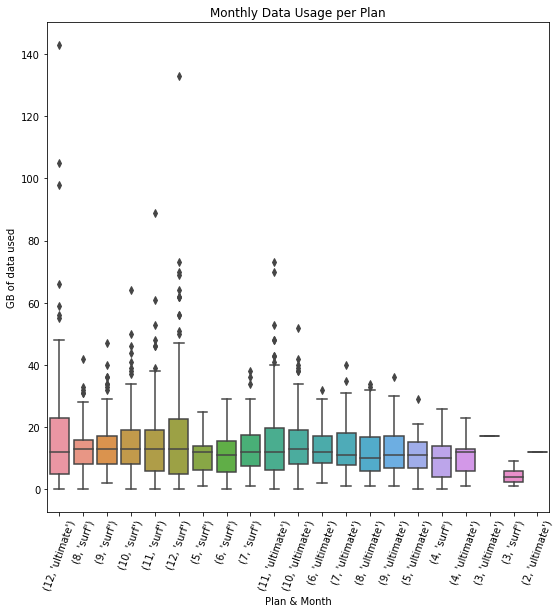

In [63]:
final_rec.groupby(["plan"])["gb_used"].sum()
y=final_rec.pivot(columns=["month", "plan"], values="gb_used")
plt.figure(figsize=(9,9))
ax=sb.boxplot(data=y)
ax.set_xticklabels(ax.get_xticklabels(),rotation=70)
plt.xlabel("Plan & Month")
plt.ylabel("GB of data used")
plt.title("Monthly Data Usage per Plan")

Text(0.5, 1.0, 'Monthly Data Usage per Plan')

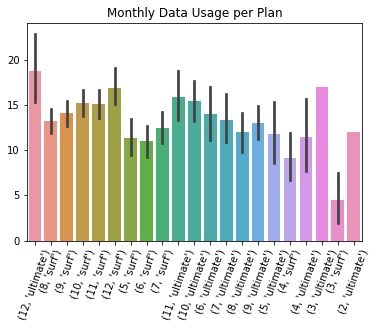

In [64]:
bar=sb.barplot(data=y)
bar.set_xticklabels(bar.get_xticklabels(),rotation=70)
plt.title("Monthly Data Usage per Plan")

* Ultimate users tend to consume more internet traffic than surf users. As shown by the boxplot in the first plot above, we can see that Ultimate users tend to exhibit higher median for data usage than surf users in most months.

## Revenue

Total Revenue: plan
surf        64723.5195
ultimate    42945.0000
Name: total_revenue, dtype: float64


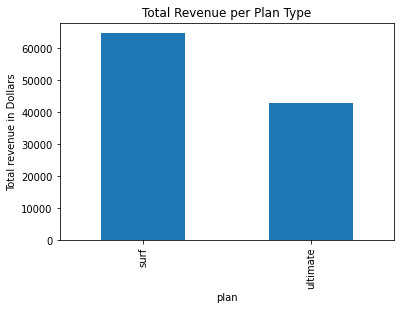

In [65]:
total_revenue=final_rec.groupby(["plan"])["total_revenue"].sum().plot(kind="bar")
rev_data=final_rec.groupby(["plan"])["total_revenue"].sum()
plt.ylabel("Total revenue in Dollars")
plt.title("Total Revenue per Plan Type")
print("Total Revenue:", rev_data)

* Clearly, Surf users generate 33% more total revenue than Ultimate users, which includes internet, calls and messages combined.

## Test statistical hypotheses

In [66]:
final_rec.groupby(["plan"])["total_revenue"].mean()


plan
surf        59.929185
ultimate    81.489564
Name: total_revenue, dtype: float64

In [67]:
from scipy import stats as st
from scipy.stats import levene 

In [68]:
sample1=surf_data["total_revenue"]
sample2=ultimate_data["total_revenue"]
print(sample1, sample2)

1       20.00
2       20.00
3       70.09
4       80.00
5       60.00
        ...  
1601    20.00
1602    30.00
1603    20.00
1604    20.00
1605    20.00
Name: total_revenue, Length: 1080, dtype: float64 0       70.0
19      70.0
20      70.0
26      70.0
27      70.0
        ... 
1566    70.0
1569    70.0
1570    70.0
1581    70.0
1606    70.0
Name: total_revenue, Length: 527, dtype: float64


In [69]:
pvalue_lev= st.levene(sample1, sample2)
pvalue_lev
print("Variance of sample 1 & 2 are not equal", pvalue_lev)

Variance of sample 1 & 2 are not equal LeveneResult(statistic=44.717152773332266, pvalue=3.1332366267343474e-11)


In [70]:
print("Null & Alternative Hypotheses:")
print("H0: The average revenue of the two plans are equal")
print("H1: The average revenue of the two plans are not equal")

Null & Alternative Hypotheses:
H0: The average revenue of the two plans are equal
H1: The average revenue of the two plans are not equal


In [71]:
def t_test(sample1, sample2, alpha=.05):
    p_value_levene=st.levene(sample1,sample2).pvalue
    if p_value_levene < alpha:
        option_var=False
    else:
        option_var=True
    p_value= st.ttest_ind(sample1, sample2, equal_var=option_var).pvalue
    print("P_value, ", p_value)
    if p_value < alpha:
        print("Reject H0, average revenue of the two plans are not equal")
    else:
        print("Fail to reject H0, average revenue of the two plans are equal")
t_test(sample1, sample2)

P_value,  4.497453688374396e-09
Reject H0, average revenue of the two plans are not equal


In [72]:
# Test the hypotheses
#Two tail test
final_rec["city"].value_counts()

New York-Newark-Jersey City, NY-NJ-PA MSA          256
Los Angeles-Long Beach-Anaheim, CA MSA             106
Chicago-Naperville-Elgin, IL-IN-WI MSA              64
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA     53
Minneapolis-St. Paul-Bloomington, MN-WI MSA         49
                                                  ... 
Dayton-Kettering, OH MSA                             2
El Paso, TX MSA                                      2
Omaha-Council Bluffs, NE-IA MSA                      2
North Port-Sarasota-Bradenton, FL MSA                1
Cape Coral-Fort Myers, FL MSA                        1
Name: city, Length: 72, dtype: int64

In [73]:
# Test the hypotheses
ny_nj_users= final_rec.query('city=="New York-Newark-Jersey City, NY-NJ-PA MSA"')
print("Revenue of NY_NJ Users:", ny_nj_users["total_revenue"])
non_nj_users=final_rec.query('city != "New York-Newark-Jersey City, NY-NJ-PA MSA"')
print("Revenue of users from other regions:", non_nj_users["total_revenue"])
#conduct a two tail test 
samplea=ny_nj_users["total_revenue"]
sampleb=non_nj_users["total_revenue"]
print(samplea)


Revenue of NY_NJ Users: 36       20.0000
52       20.0000
53       20.0000
54       60.0000
55      200.0000
          ...   
1596     40.0000
1597     20.0000
1598     32.5746
1599     20.0000
1600     20.0000
Name: total_revenue, Length: 256, dtype: float64
Revenue of users from other regions: 0       70.00
1       20.00
2       20.00
3       70.09
4       80.00
        ...  
1602    30.00
1603    20.00
1604    20.00
1605    20.00
1606    70.00
Name: total_revenue, Length: 1351, dtype: float64
36       20.0000
52       20.0000
53       20.0000
54       60.0000
55      200.0000
          ...   
1596     40.0000
1597     20.0000
1598     32.5746
1599     20.0000
1600     20.0000
Name: total_revenue, Length: 256, dtype: float64


In [74]:
def t_test2(samplea, sampleb, alpha=.05):
    p_value_levene2=st.levene(samplea,sampleb).pvalue
    if p_value_levene < alpha:
        option_var2=False
    else:
        option_var2=True
    p_value2= st.ttest_ind(samplea, sample2, equal_var=option_var2).pvalue
    print("P_value, ", p_value2)
    if p_value2 < alpha:
        print("Reject H0, average revenue of the two plans are not equal")
    else:
        print("Fail to reject H0, average revenue of the two plans are equal")
t_test(samplea, sampleb)

P_value,  0.7705537505808494
Fail to reject H0, average revenue of the two plans are equal


# OVERVIEW
* This dataset consisted of 5 seperate tables, which were eventually merged together to consolidate all of the data for analysis. The only missing data was found in the "Users" table in the churn["date"] column which indicated the date the user terminated their respective plan. If there were NaN values in this column, the assumption would be that the user is still currently on that plan. For this reason, all NaN values in that column were replaced with "current_user". 
* All columns containing date information were converted to datetime objects to make them more useful. Additional columns were created in some of the tables to reflect month based on existing date columns, and aggregate data such as the monthly call duration, data usage and messages per user. In order to create a single record containing the necessary information for analysis, the data tables were merged one by one on the columns "user_id" and/or "month. 

# CONCLUSION
* An independent samples t-test was conducted to test the hypothesis that the average revenue from users of the Ultimate and Surf calling plans differs. Based on the results, the null hypothesis was rejected, concluding that the average revenue of the two plans are not equal (p-value=4.4019654856893925e-09).

* A second independent samples t-test was conducted to test the hypothesis that the average revenue from users in the NY-NJ area is different from that of the users from the other regions. The results of the test indicate that we fail to reject the null hypothesis, concluding that the average revenue of the two plans are equal(p-value=0.7833071445775941).

* As mentioned throughout this project, the sample size of each plan differs considerably, as Ultimate user data contained nearly 49% less rows than Surf user data. Further statistical tests should be conducted utilizing larger samples (and equal samples) in order to better understand how these samples differ and in what direction.